# Anomaly Detection in Smart Meter Data

## by M. Baez, K. Golubev, X. Wang, 28-29 Aug 2020

## in collaboration with [meterOS](https://hack.opendata.ch/project/598)

### for questions and suggestions contact [Konstantin Golubev](https://www.linkedin.com/in/konstantin-golubev-phd-843625173/) at k.golubev@gmail.com

This notebook contains EDA and algorithms developed for the Anomaly Detection in Smart Meter Data challenge. The challenge was presented at the [Enery Data Hackdays 2020](https://opendata.ch/projects/energy-data-hackdays-2020/) by Clemap. 

The data set contains a time series of reading from a single smart meter.

In this notebook, we present 
    1. Clustering Approach for detecting anomolous days based on mean and std of the readings during the day.
    2. Monte Carlo Approach for detecting single anomolous readings.

### Challenge Description

Energy consumption in buildings and industry is often wasted due to user behaviour, human error, and poorly performing equipment. In this context, identifying abnormal consumption power behavior can be an important part of reducing peak energy consumption and changing undesirable user behavior. With the widespread rollouts of smart meters, normal operating consumption can be learned over time and used to identify or flag abnormal consumption. Such information can help indicate to users when their equipment is not operating as normal and can help to change user behavior or to even indicate what the problem appliances may be to implement lasting changes.

This challenge is looking for data scientists to apply their skills to an anomaly detection problem using smart meter data. Ideally, such an algorithm should begin to operate after as little as 3 months and should improve over time. A platform to visualise the anomalies would also be useful. Users can select any type of machine learning algorithms that they wish to in order to detect the anomalies from the data.

### Data
A sample including smart meter data can be found on [kaggle](https://www.kaggle.com/portiamurray/anomaly-detection-smart-meter-data-sample). Participants are encouraged to find other smart meter data to work with in order to test their algorithms.

### Imports

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import random
import collections as cl

In [2]:
data = pd.read_excel('SmartMeterSample.xlsx')

In [3]:
data.head()

,Datum Zeit,Messung Gebäude 2ewz [kWh]
0,2016-01-01 00:15:00,2.85
1,2016-01-01 00:30:00,2.85
2,2016-01-01 00:45:00,3.00
3,2016-01-01 01:00:00,2.94
4,2016-01-01 01:15:00,2.79


### Rename columns, remove duplicate values, make timestamp index

In [4]:
data.columns = ['datetime','kWh']

# make datetimestamp the index in the original dataset
data = data.set_index('datetime')

# delete duplicates from the original dataset
data = data[~data.index.duplicated(keep='first')] 

## First graphs

The dataset is a single timeseries, i.e., a reading of the meter in kWh every 15 minutes. We first plot the histogram of the readings, and observe that the values are distributed mainly around two values (approx., 2.75 and 7). This hints that the values correspond to the "idle" around 2.75 kWh, and the "active" movde around 7 kWh.

/scratch/users/golubevk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


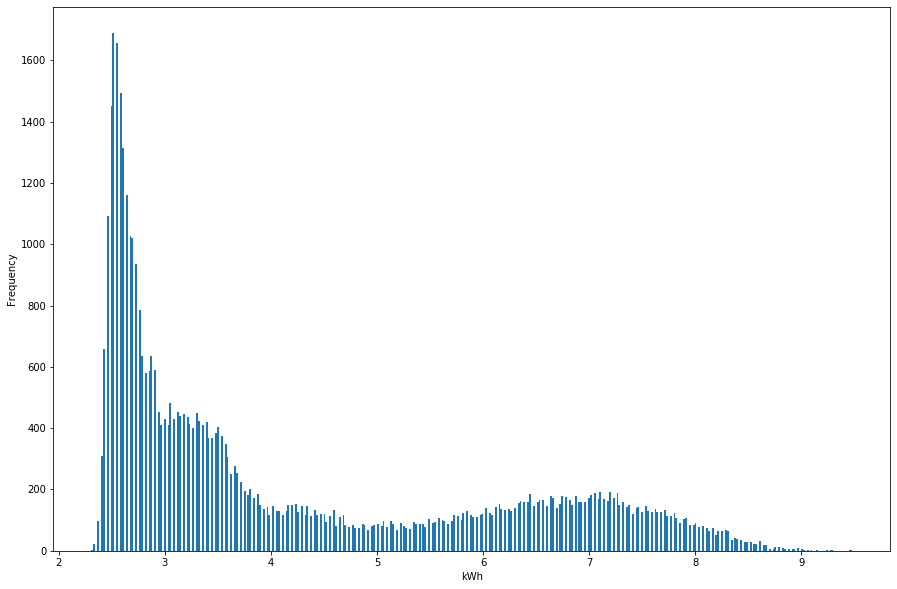

In [5]:
plt.rcParams['figure.figsize'] = [15, 10] # plot size width and height
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_facecolor('#FFFFFF')
ax.set_xlabel('kWh')
ax.set_ylabel('Count')
ax.tick_params(colors='k')
ax.yaxis.label.se t_color('k')
ax.xaxis.label.set_color('k')
data['kWh'].plot(kind = 'hist', bins = 400)
fig.show()

Since the data is a time series, but might have missing values or duplicates, we create a new data frame indexed by datetime stamps within the range of the original data stamps. We initialize the values with NaN, and then fill them in with the data.

In [6]:
from datetime import datetime, timedelta

# this is a function that generates timestamps from START to END with the step of DELTA

def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

In [7]:
# We find the START and END from the dataset, i.e., the first and the last datestamps.
START, END = data.index[0], data.index[-1]
START, END

(Timestamp('2016-01-01 00:15:00'), Timestamp('2017-05-11 00:00:00'))

In [8]:
# generate timestamps for the whole period with the function datetime_range starting on START, ending on END. The delta is equal to 15 minutes
# construct a dataframe indexed by the timestamps
df = pd.DataFrame(datetime_range(START, END, timedelta(minutes=15)))
df.columns = ['datetime']
df['kWh'] = np.nan
df = df.set_index('datetime')
df.head()

,kWh
datetime,
2016-01-01 00:15:00,NaN
2016-01-01 00:30:00,NaN
2016-01-01 00:45:00,NaN
2016-01-01 01:00:00,NaN
2016-01-01 01:15:00,NaN


In [9]:
# fill in the DF dataset with values from the original dataset DATA, output a message if the value is missing
for index,row in df.iterrows():
    if index in data.index:
        df.loc[index]['kWh'] = data.loc[index]['kWh']
    else:
        print('Missing value at ', index)

Missing value at  2016-03-27 02:00:00
Missing value at  2016-03-27 02:15:00
Missing value at  2016-03-27 02:30:00
Missing value at  2016-03-27 02:45:00
Missing value at  2016-11-10 01:45:00
Missing value at  2017-02-24 00:00:00
Missing value at  2017-02-24 00:15:00
Missing value at  2017-02-24 00:30:00
Missing value at  2017-02-24 00:45:00
Missing value at  2017-02-24 01:00:00
Missing value at  2017-02-24 01:15:00
Missing value at  2017-02-24 01:30:00
Missing value at  2017-02-24 01:45:00
Missing value at  2017-02-24 02:00:00
Missing value at  2017-02-24 02:15:00
Missing value at  2017-02-24 02:30:00
Missing value at  2017-02-24 02:45:00
Missing value at  2017-02-24 03:00:00
Missing value at  2017-02-24 03:15:00
Missing value at  2017-02-24 03:30:00
Missing value at  2017-02-24 03:45:00
Missing value at  2017-02-24 04:00:00
Missing value at  2017-02-24 04:15:00
Missing value at  2017-02-24 04:30:00
Missing value at  2017-02-24 04:45:00
Missing value at  2017-02-24 05:00:00
Missing valu

We add columns 'date','hour', 'weekday', 'workday' for a more detailed EDA. We also reset indices, i.e., datetime stamp becomes a column.

In [10]:
df.reset_index(inplace = True)
df['date'] = df.apply(lambda row: row['datetime'].date(), axis = 1)
df['weekday'] = df.apply(lambda row: row['datetime'].weekday(), axis = 1)
df['workday'] = df.apply(lambda row: row['weekday'] < 5, axis = 1)
df['hour'] = df.apply(lambda row: row['datetime'].hour, axis = 1)

In [11]:
df.head()

,datetime,kWh,date,weekday,workday,hour
0,2016-01-01 00:15:00,2.85,2016-01-01,4,True,0
1,2016-01-01 00:30:00,2.85,2016-01-01,4,True,0
2,2016-01-01 00:45:00,3.00,2016-01-01,4,True,0
3,2016-01-01 01:00:00,2.94,2016-01-01,4,True,1
4,2016-01-01 01:15:00,2.79,2016-01-01,4,True,1


### Average consumption per day of the week

In [12]:
weekday_labels = ['Mo','Tu','We','Th','Fr','Sa','Su']

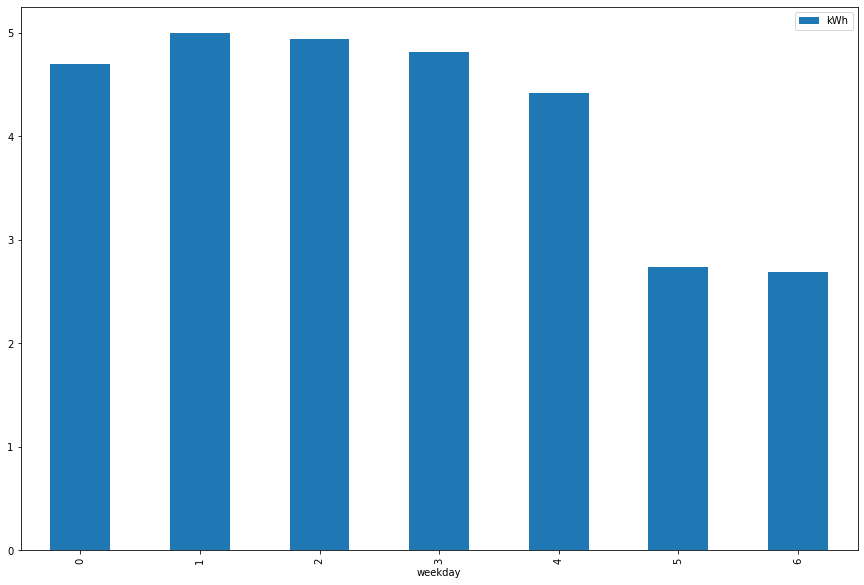

In [13]:
df[['weekday', 'kWh']].groupby(['weekday']).mean().plot(kind = 'bar')


The above graph shows that on the working days (0 -- Mo, 4 -- Fr) the consumption is higher, implying that the meter is probably installed at an office rather than a household.

### Average consumption per hour

In [14]:
df['hour'] = df.apply(lambda row: row['datetime'].hour, axis=1)

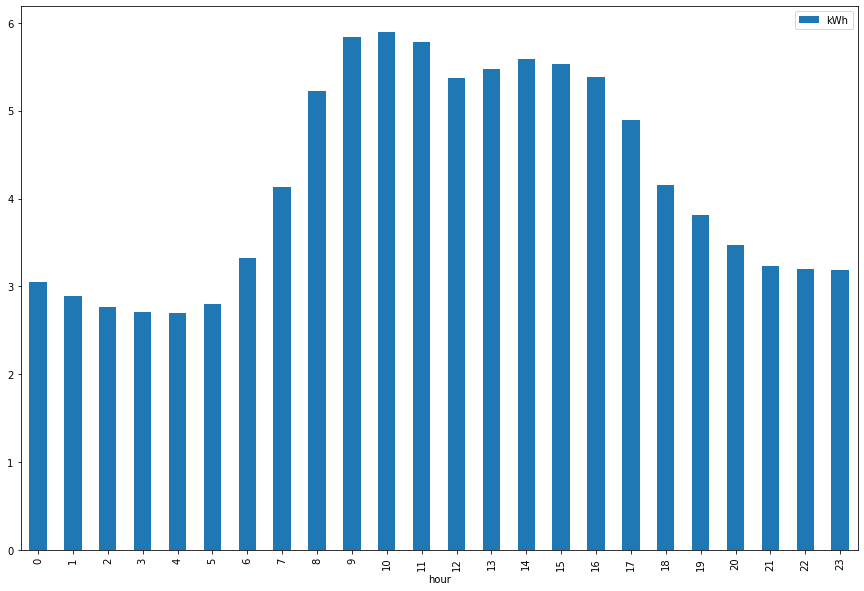

In [15]:
df[['hour', 'kWh']].groupby(['hour']).mean().plot(kind = 'bar')

### Average consumption per month

In [16]:
df['month'] = df.apply(lambda row: row['datetime'].month, axis=1)

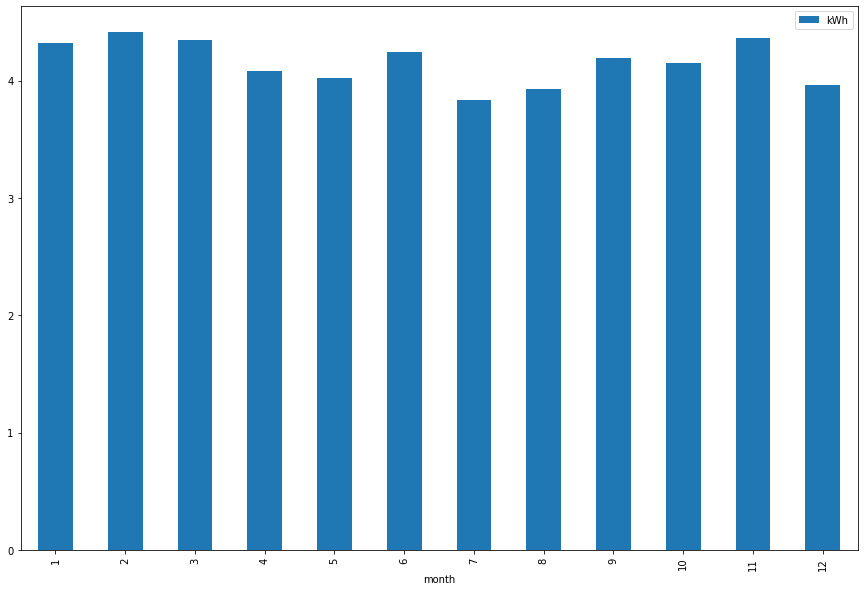

In [17]:
df[['month', 'kWh']].groupby(['month']).mean().plot(kind = 'bar')

### How does a typical workday vs weekend look like?

Create a new data frame aggregated from df by weekday and hour

In [18]:
df_day_hour = df[['weekday','hour', 'kWh']].groupby(['weekday','hour']).mean()
df_day_hour.reset_index(inplace = True)
df_day_hour

,weekday,hour,kWh
0,0,0,2.720810
1,0,1,2.661761
2,0,2,2.632923
3,0,3,2.596901
4,0,4,2.585176
...,...,...,...
163,6,19,2.722394
164,6,20,2.718592
165,6,21,2.760845
166,6,22,2.764648


/scratch/users/golubevk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


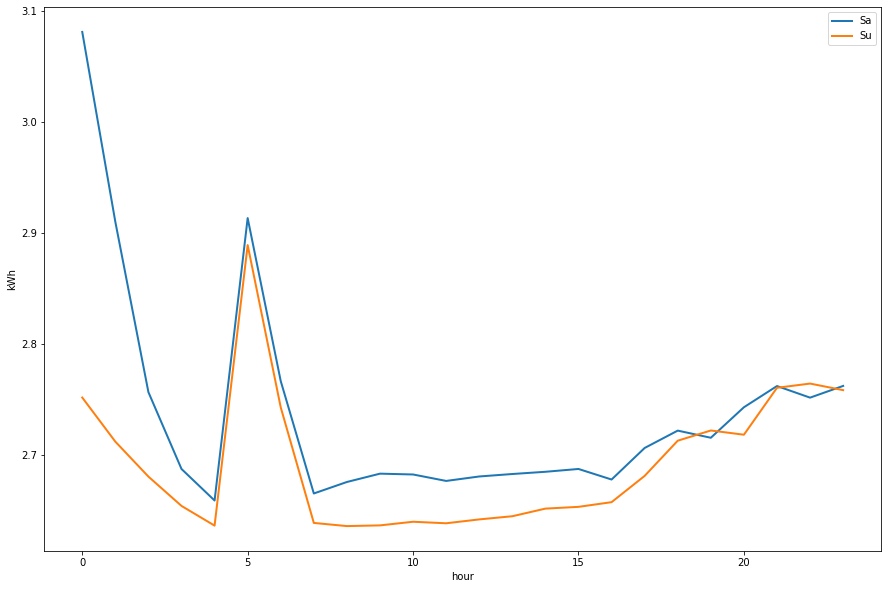

In [19]:
plt.rcParams['figure.figsize'] = [15, 10] # plot size width and height
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_facecolor('#FFFFFF')
ax.set_xlabel('hour')
ax.set_ylabel('kWh')
ax.tick_params(colors='k')
ax.yaxis.label.set_color('k')
ax.xaxis.label.set_color('k')
for idx in range(5,7):
    plt.plot(df_day_hour[df_day_hour['weekday'] == idx]['hour'],df_day_hour[df_day_hour['weekday'] == idx]['kWh'], linewidth=2, label = weekday_labels[idx])
plt.legend()
fig.show()

We can observe that the readings are around 2.75 during weekends with a pick around 5:15. This might indicate that something is being turned out automatically at this time. 

/scratch/users/golubevk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


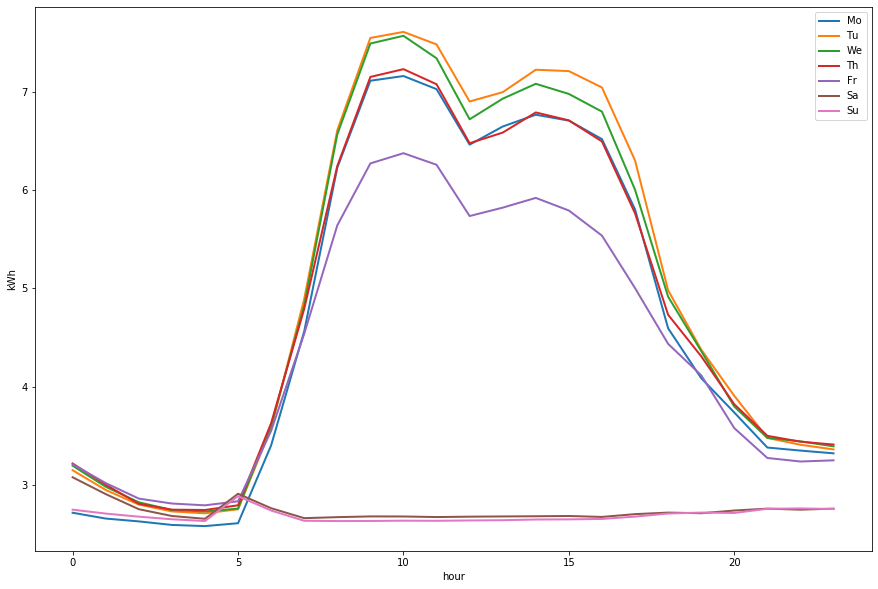

In [20]:
plt.rcParams['figure.figsize'] = [15, 10] # plot size width and height
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_facecolor('#FFFFFF')
ax.set_xlabel('hour')
ax.set_ylabel('kWh')
ax.tick_params(colors='k')
ax.yaxis.label.set_color('k')
ax.xaxis.label.set_color('k')
for idx in range(7):
    plt.plot(df_day_hour[df_day_hour['weekday'] == idx]['hour'],df_day_hour[df_day_hour['weekday'] == idx]['kWh'], linewidth=2, label = weekday_labels[idx])
plt.legend()
fig.show()


We can guess from the graphs above that:
1. Something is being turned on at 5:00 on the weekends.
2. There is residual consumption from workdays (see Saturday morning) -- heating, A/C?
3. There is a lunch break at around 12:00 -- 13:00, and consumption drops after it. 
4. The load is lower on Fridays.

# Let's find anomouls days

We aggregate the readings for each day in the mean and std values.

In [21]:
f = {'kWh': ['mean', 'std'], 'workday': 'mean', 'weekday': ['mean'], 'month':'mean'}
df_day = df.groupby('date').agg(f)


In [22]:
df_day = df_day.dropna()
df_day

kWh           workday weekday month
                mean       std    mean    mean  mean
date                                                
2016-01-01  2.754000  0.087585    True       4     1
2016-01-02  2.723125  0.036283   False       5     1
2016-01-03  2.725937  0.035528   False       6     1
2016-01-04  5.222500  2.211100    True       0     1
2016-01-05  5.040938  2.022156    True       1     1
...              ...       ...     ...     ...   ...
2017-05-06  3.014375  0.089099   False       5     5
2017-05-07  3.027812  0.083982   False       6     5
2017-05-08  5.157812  2.043110    True       0     5
2017-05-09  5.167500  1.916844    True       1     5
2017-05-10  4.946250  1.681591    True       2     5

[496 rows x 5 columns]

In [23]:
df_day.columns = ['kWh-mean', 'kWh-std', 'workday', 'weekday','month']

On the plot below each day represents a day with Blue standing for Mo-Fr, and Green fro Sa-Su. As it can be seen, there are two big clusters (Blue and Green). However, some blue points fall into the green cluster, and the guess is that these are the non-working Mo-Fr days.

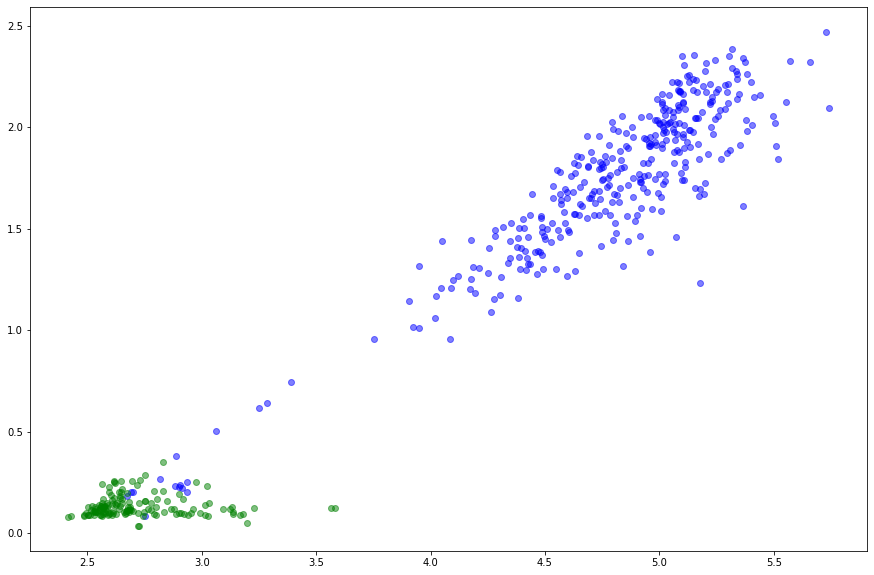

In [24]:
plt.plot(df_day[df_day['workday']]['kWh-mean'], df_day[df_day['workday']]['kWh-std'], 'bo', alpha = 0.5)
plt.plot(df_day[~df_day['workday']]['kWh-mean'], df_day[~df_day['workday']]['kWh-std'], 'go', alpha = 0.5)

In order to find the anomalies, we run clustering algorithms. Below we run the DBSCAN algorithm.

   ### DBSCAN clustering of days

In [25]:
X = df_day[['kWh-mean','kWh-std']]
X = StandardScaler().fit_transform(X)

In [26]:
db = DBSCAN(eps = 0.15, min_samples = 3).fit(X)
for l in set(db.labels_):
    print('The number of day labeled ', l, ' is ', sum(db.labels_ == l))

The number of day labeled  0  is  152
The number of day labeled  1  is  330
The number of day labeled  -1  is  14


In [27]:
df_day['DB-label'] = db.labels_

/scratch/users/golubevk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


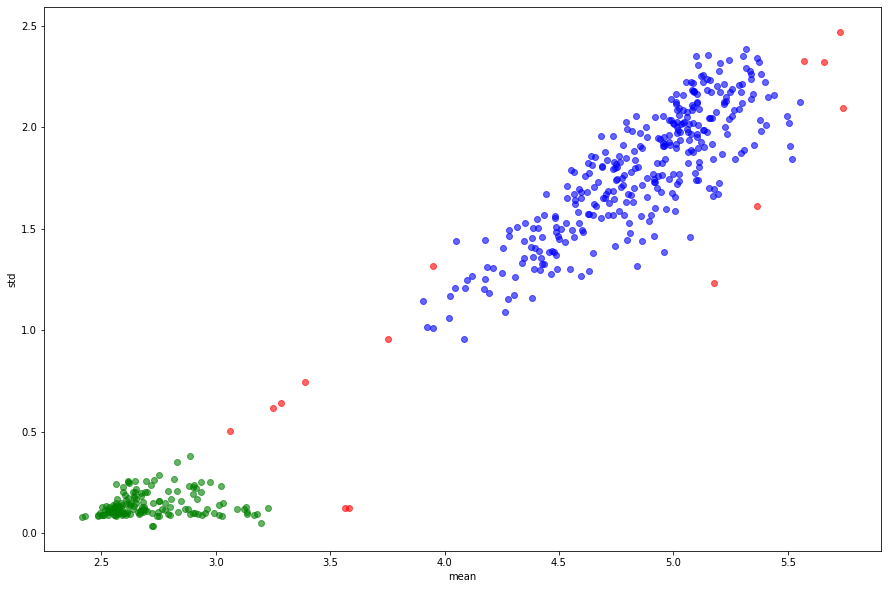

In [28]:
plt.rcParams['figure.figsize'] = [15, 10] # plot size width and height
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_facecolor('#FFFFFF')
ax.set_xlabel('mean')
ax.set_ylabel('std')
ax.tick_params(colors='k')
ax.yaxis.label.set_color('k')
ax.xaxis.label.set_color('k')
plt.plot(df_day[df_day['DB-label']==0]['kWh-mean'], df_day[df_day['DB-label']==0]['kWh-std'], 'go', alpha = 0.6)
plt.plot(df_day[df_day['DB-label']==1]['kWh-mean'], df_day[df_day['DB-label']==1]['kWh-std'], 'bo', alpha = 0.6)
plt.plot(df_day[~(df_day['DB-label']==0) & ~(df_day['DB-label']==1)]['kWh-mean'], df_day[~(df_day['DB-label']==0) & ~(df_day['DB-label']==1)]['kWh-std'], 'ro', alpha = 0.6)
fig.show()



Here two outliers are colored red.

In [29]:
df_day_outliers = df_day[~(df_day['DB-label']==1) & ~(df_day['DB-label']==0)]
df_day_outliers.reset_index(inplace = True)
df_day_outliers

,date,kWh-mean,kWh-std,workday,weekday,month,DB-label
0,2016-01-11,5.729375,2.469152,True,0,1,-1
1,2016-01-19,5.741875,2.094446,True,1,1,-1
2,2016-04-07,5.364688,1.609786,True,3,4,-1
3,2016-05-06,3.390313,0.743925,True,4,5,-1
4,2016-07-29,3.750938,0.959234,True,4,7,-1
5,2016-09-12,3.947813,1.317195,True,0,9,-1
6,2016-12-27,3.283125,0.641051,True,1,12,-1
7,2016-12-28,3.249375,0.619488,True,2,12,-1
8,2016-12-29,3.063125,0.503193,True,3,12,-1
9,2017-01-24,5.659688,2.321195,True,1,1,-1


### Let's go over outliers one by one

We plot the kWh data from each outlier day together with a *random* day with the same weekday value.

In [30]:
num_outliers = len(df_day_outliers)
num_outliers

14

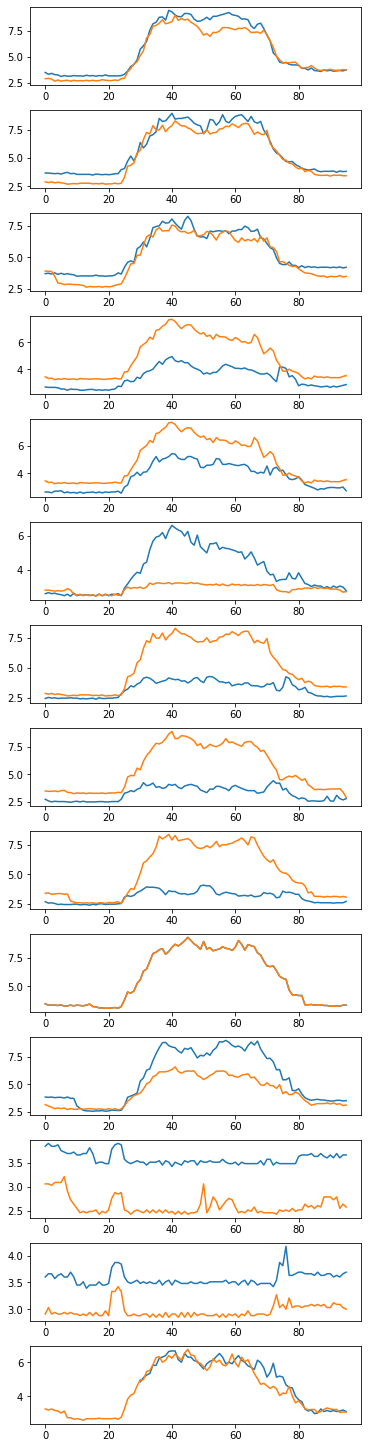

In [31]:
plt.rcParams['figure.figsize'] = [5, 20] # plot size width and height

fig, ax = plt.subplots(nrows=num_outliers, ncols=1, constrained_layout=True)

for ido, row in enumerate(ax):
    # what day of the week it is
    wd = int(df[df['date'] == df_day_outliers.iloc[ido]['date']]['weekday'].max());
    # find index of a random day with the same weekday value
    l = len(df[df['weekday'] == wd])
    idr = random.randint(0,l-1)
    idr_date = df[df['weekday'] == wd].iloc[idr]['date']
    row.plot(df[df['date'] == df_day_outliers.iloc[ido]['date']].reset_index()['kWh'])
    row.plot(df[df['date'] == idr_date].reset_index()['kWh'])
    

plt.show()

### Conclusions
Mostly the outliers are days on which the consumptions follows the pattern of either a weekday or a weekend. One outlier is a day on which measurements for the first 7 hours are missing.


## Mean Shift Clustering


In [32]:
X = df_day[['kWh-mean','kWh-std']]

from sklearn.cluster import MeanShift,estimate_bandwidth
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)
clustering = MeanShift(bandwidth=bandwidth).fit(X)

for l in set(clustering.labels_):
    print('The number of day labeled ', l, ' is ', sum(clustering.labels_ == l))

df_day['MeanShift-label'] = clustering.labels_


The number of day labeled  0  is  327
The number of day labeled  1  is  144
The number of day labeled  2  is  15
The number of day labeled  3  is  10


/scratch/users/golubevk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


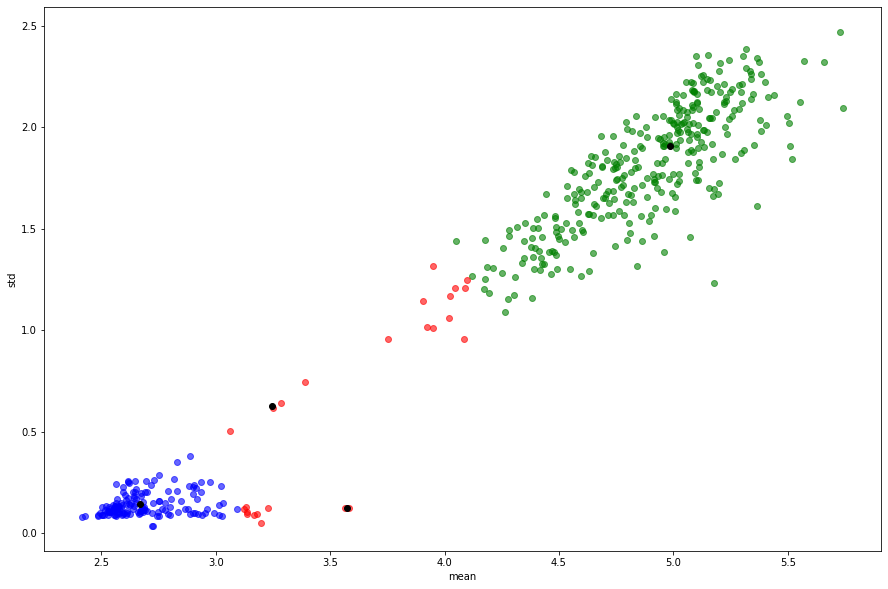

In [33]:
plt.rcParams['figure.figsize'] = [15, 10] # plot size width and height
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_facecolor('#FFFFFF')
ax.set_xlabel('mean')
ax.set_ylabel('std')
ax.tick_params(colors='k')
ax.yaxis.label.set_color('k')
ax.xaxis.label.set_color('k')
plt.plot(df_day[df_day['MeanShift-label']==0]['kWh-mean'], df_day[df_day['MeanShift-label']==0]['kWh-std'], 'go', alpha = 0.6)
plt.plot(df_day[df_day['MeanShift-label']==1]['kWh-mean'], df_day[df_day['MeanShift-label']==1]['kWh-std'], 'bo', alpha = 0.6)
plt.plot(df_day[~(df_day['MeanShift-label']==0) & ~(df_day['MeanShift-label']==1)]['kWh-mean'], df_day[~(df_day['MeanShift-label']==0) & ~(df_day['MeanShift-label']==1)]['kWh-std'], 'ro', alpha = 0.6)
plt.plot([x[0] for x in clustering.cluster_centers_], [x[1] for x in clustering.cluster_centers_], 'ko')
fig.show()


Here two outliers are colored red. Black dots are the cluster centers. 

In [34]:
df_day_outliers = df_day[~(df_day['MeanShift-label']==1) & ~(df_day['MeanShift-label']==0)]
df_day_outliers.reset_index(inplace = True)


### Let's go over outliers one by one



We plot the kWh data from each outlier day together with a *random* day with the same weekday value.


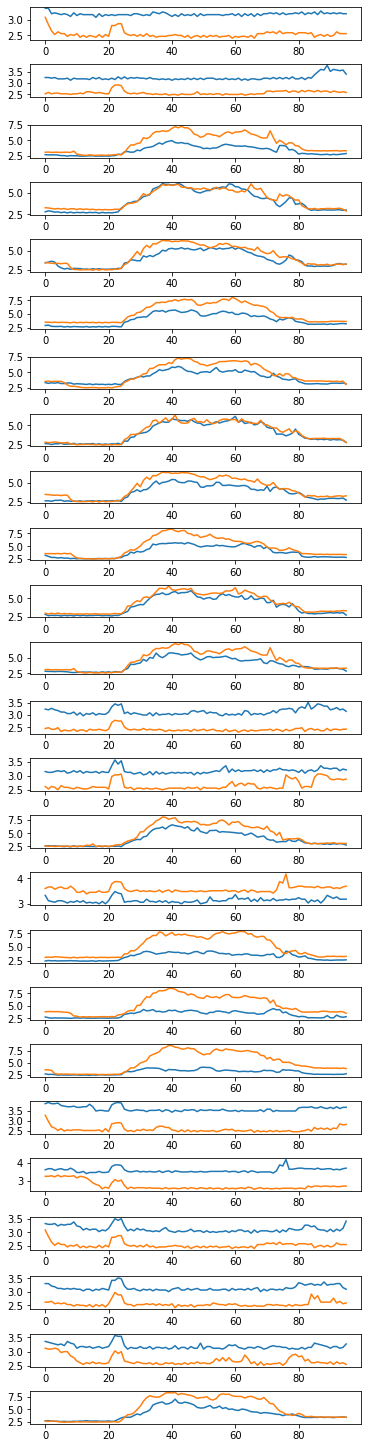

In [35]:
num_outliers = len(df_day_outliers)
num_outliers

plt.rcParams['figure.figsize'] = [5, 20] # plot size width and height

fig, ax = plt.subplots(nrows=num_outliers, ncols=1, constrained_layout=True)

for ido, row in enumerate(ax):
    # what day of the week it is
    wd = int(df[df['date'] == df_day_outliers.iloc[ido]['date']]['weekday'].max());
    # find index of a random day with the same weekday value
    l = len(df[df['weekday'] == wd])
    idr = random.randint(0,l-1)
    idr_date = df[df['weekday'] == wd].iloc[idr]['date']
    row.plot(df[df['date'] == df_day_outliers.iloc[ido]['date']].reset_index()['kWh'])
    row.plot(df[df['date'] == idr_date].reset_index()['kWh'])
    

plt.show()

### Conclusions

One advantage of the Mean-Shift algorithm over the DBSCAN algorithm is that it produces centers of the clusters (they are used for clustering), and hence can be more easily adapted for online algorithms. DBSCAN would require recomputing the clustering with a new batch of data.

## Other time windows

A similar analysis can be carried out for time windows of size other than 24 hours, and for sliding windows rather than a frame. Below we plot 'mean vs std' of frames of 1 hour.

In [36]:
f = {'kWh': ['mean', 'std'], 'workday': 'mean', 'weekday': 'mean'}
df_hour = df.groupby(['date', 'hour']).agg(f)
df_hour.reset_index(inplace = True)
df_hour.columns = ['date', 'hour', 'kWh-mean', 'kWh-std', 'workday', 'weekday']
df_hour

,date,hour,kWh-mean,kWh-std,workday,weekday
0,2016-01-01,0,2.9000,0.086603,True,4
1,2016-01-01,1,2.8050,0.099499,True,4
2,2016-01-01,2,2.7075,0.028723,True,4
3,2016-01-01,3,2.7225,0.037749,True,4
4,2016-01-01,4,2.7150,0.017321,True,4
...,...,...,...,...,...,...
11899,2017-05-10,19,4.2750,0.458585,True,2
11900,2017-05-10,20,3.6825,0.089582,True,2
11901,2017-05-10,21,3.5925,0.061847,True,2
11902,2017-05-10,22,3.5475,0.045000,True,2


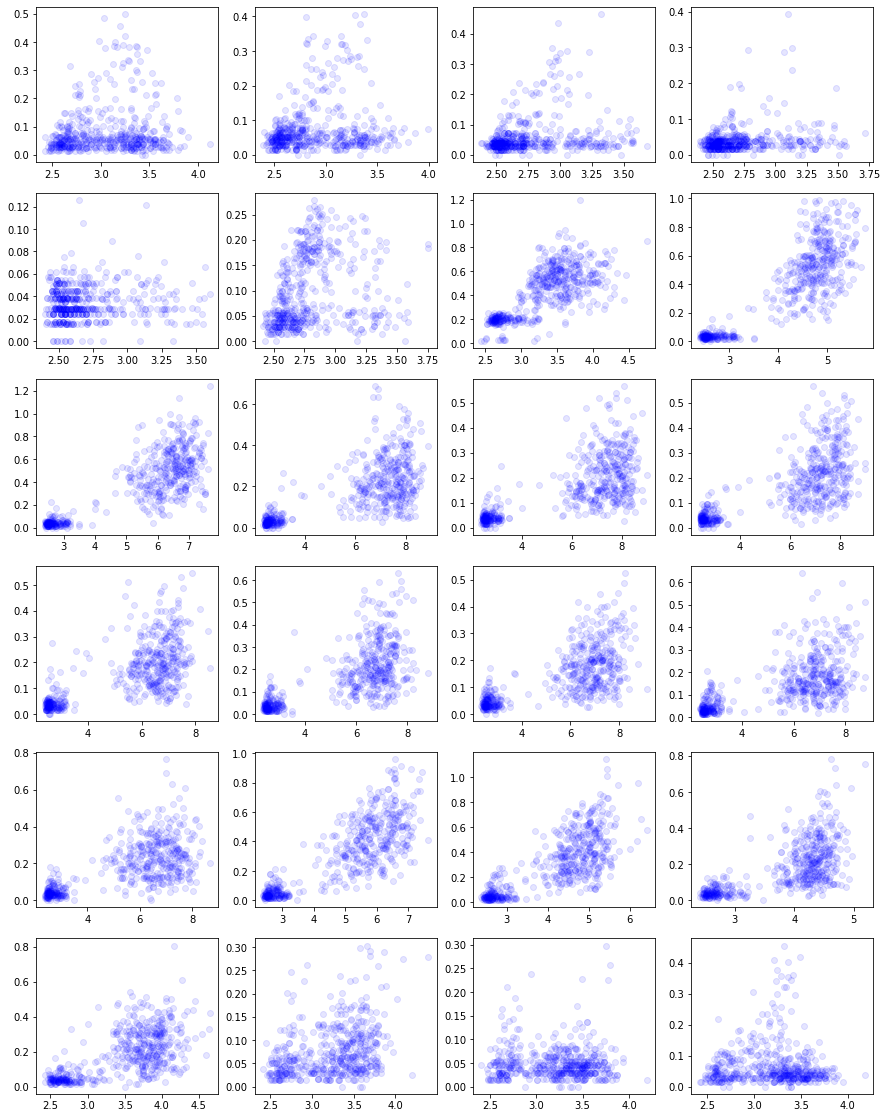

In [37]:
plt.rcParams['figure.figsize'] = [15, 20] # plot size width and height

for h in range(24):
    plt.subplot(6,4,h+1)
    plt.plot(df_hour[(df_hour['hour'] == h)]['kWh-mean'], df_hour[(df_hour['hour'] == h)]['kWh-std'], 'bo', alpha = 0.1)
plt.show()

## Monte Carlo classification of single measurements

For every reading, we calculate the frequency of appearance of this reading in the past, and write to the 'freq' column of the dataframe. For missing readings we define the frequency to be -1. A reading is declared anomolous if its frequency is below a set threshold. The value of the threshold can be also used for estimating the severity of the anomaly. 

The pros of this approach:
    1. Easy and fast.
    2. Tunable.
    3. Adaptive: if the user behaviour changes, algorithm eventually adapts to the new behaviour. This can also be achieved by reseting the clock, i.e., reseting the appr dictionary and the count variable after count reaches certain threshold, or by setting time-to-live for each reading in the past. 

In [38]:
df['freq'] = 0
appr = cl.defaultdict(float)
count = 0
alert_threshold = 0.001
reset_time = -1

for index, row in df.iterrows():
    val = row['kWh']
    if pd.isna(val):
        #print('Missing value at ', index)
        df.loc[index,'freq']= -1
    else:
        count += 1
        if val in appr:
            appr[val] += 1
        else:
            appr[val] = 1
        df.loc[index,'freq'] = appr[val]/count
            
    if count == reset_time:
        appr = cl.defaultdict(float)
        count = 0

/scratch/users/golubevk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


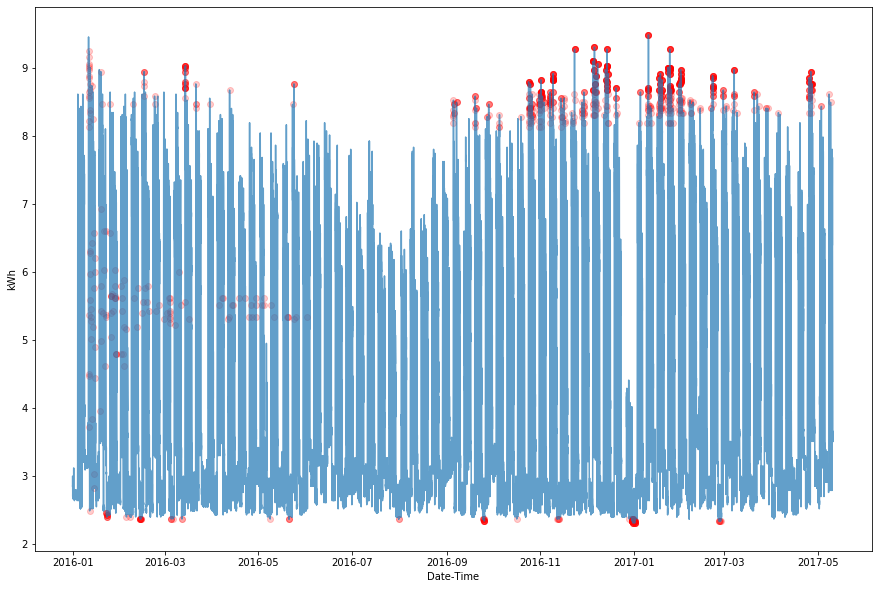

In [39]:
plotdf = df.reset_index()

anomaly_threshold = 0.001
plt.rcParams['figure.figsize'] = [15, 10] # plot size width and height
fig, ax = plt.subplots()
ax.set_xlabel('Date-Time')
ax.set_ylabel('kWh')
ax.plot(plotdf['datetime'], plotdf['kWh'], alpha = 0.7)

for step in range(3):
    ax.scatter(plotdf.loc[plotdf['freq'] < anomaly_threshold/(step+1)]['datetime'], plotdf.loc[plotdf['freq'] <anomaly_threshold/(step+1)]['kWh'], color='red', alpha = 0.2 * (step+1))
fig.show()

On this graph, the red points are the detected outliers with the transperancy depending on the severity of the anomaly. Brighter red corresponds to higher severity.

### Last edit on 31 Aug 2020.
### Konstantin Golubev, k.golubev@gmail.com